# Bike Sharing Trends in the San Franciso Bay Area
## by Stefan Schonauer

## Investigation Overview

The goal of this investigation is finding trends in departure rides. I try to find patterns and relationships regarding geographical coordinates and user types. Furthermore I investigate the day and time of departure.

## Dataset Overview

This data set includes around 180,000 bike rides in the San Francisco Bay Area from February 2019. 
Additional features are departure and arrival stations, geographical coordinates, ride duration, bike data and personal data of the rider. Some data types were changed for later investigation and 197 rows were removed because of mission station information. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe

bike_raw = pd.read_csv('201902-fordgobike-tripdata.csv')

# cleaning data 

# drop null value stations

bike_raw_na = bike_raw.index[bike_raw.end_station_id.isnull()]
bike_raw.drop(bike_raw_na, inplace = True)

# duration_sec to float

bike_raw.duration_sec = bike_raw.duration_sec.astype('float')

# start and end time to datetime

bike_raw.start_time = pd.to_datetime(bike_raw.start_time, yearfirst = True, errors='coerce')
bike_raw.end_time = pd.to_datetime(bike_raw.end_time, yearfirst = True, errors='coerce')

# station id to str

bike_raw.start_station_id = bike_raw.start_station_id.astype('int')
bike_raw.start_station_id = bike_raw.start_station_id.astype('str')
bike_raw.end_station_id = bike_raw.end_station_id.astype('int')
bike_raw.end_station_id = bike_raw.end_station_id.astype('str')

# bike id to str

bike_raw.bike_id = bike_raw.bike_id.astype('str')

# reset index

bike_raw.reset_index(drop = True, inplace = True)

bike = bike_raw.copy()

In [3]:
# create column 'station_multi' 0 -> start_station == end_station; 1 -> start_station != end_station

bike['station_multi'] = np.where(bike.start_station_id == bike.end_station_id, 0, 1)

# create columns for duration in [min] and [h]

bike['duration_min'] = bike.duration_sec / 60
bike['duration_hour'] = bike.duration_min / 60

# day of week (Monday=0, Sunday=6)

bike['start_time_day_of_week'] = bike.start_time.dt.dayofweek
bike['start_time_day_of_week_name'] = bike.start_time.dt.day_name()

# hour of day

bike['start_time_day'] = bike.start_time.dt.day
bike['start_time_hour'] = bike.start_time.dt.hour

# Create a column 'region'

conditions = [(bike.start_station_longitude <= -122.35),
              (bike.start_station_longitude > -122.35) & (bike.start_station_longitude <= -122.1),
              (bike.start_station_longitude > -122.1)]
            
values = ['West', 'Central', 'East']

bike['region'] = np.select(conditions, values)

In [4]:
# basic diagram settings

base_color = sb.color_palette()[0]

region_order = ['West', 'Central', 'East']
user_type_order = ['Customer', 'Subscriber']

## Distribution and Number of Departure Stations

There are 329 departure stations in the data set. Frequency of the stations defines rides. Number of rides per departure station is unequal distibuted. There is a range of one ride up to almost 4,000 rides. The ten most relevant stations have a frequency of least 1,500 rides. 

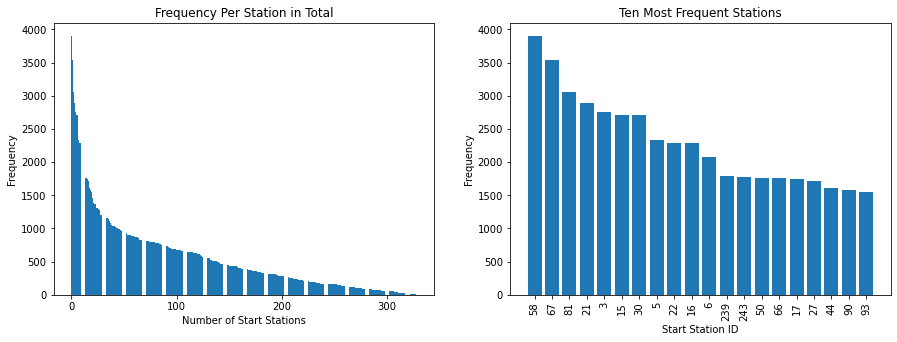

In [5]:
# create temporary data frame

df_bike_temp = bike.groupby(['start_station_name', 'start_station_id'])['station_multi'].count().reset_index().sort_values(by = 'station_multi', ascending = False)

plt.figure(figsize = [15, 5]) 

plt.subplot(1, 2, 1) 
x = df_bike_temp.start_station_id
y = df_bike_temp.station_multi

plt.title('Frequency Per Station in Total')
plt.xlabel('Number of Start Stations')
plt.ylabel('Frequency')
plt.xticks([0, 100, 200, 300], [0, 100, 200, 300])
plt.bar(x, y)

plt.subplot(1, 2, 2)
x = df_bike_temp.start_station_id[0:20]
y = df_bike_temp.station_multi[0:20]

plt.title('Ten Most Frequent Stations')
plt.xlabel('Start Station ID')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.bar(x, y);

## Geographical Distribution of Departure Stations

Stations can be grouped into three main regions 'west', 'central' and 'east'. Stations with most departures are located in the west region. The darker and bigger scatters appear the more departures take place.

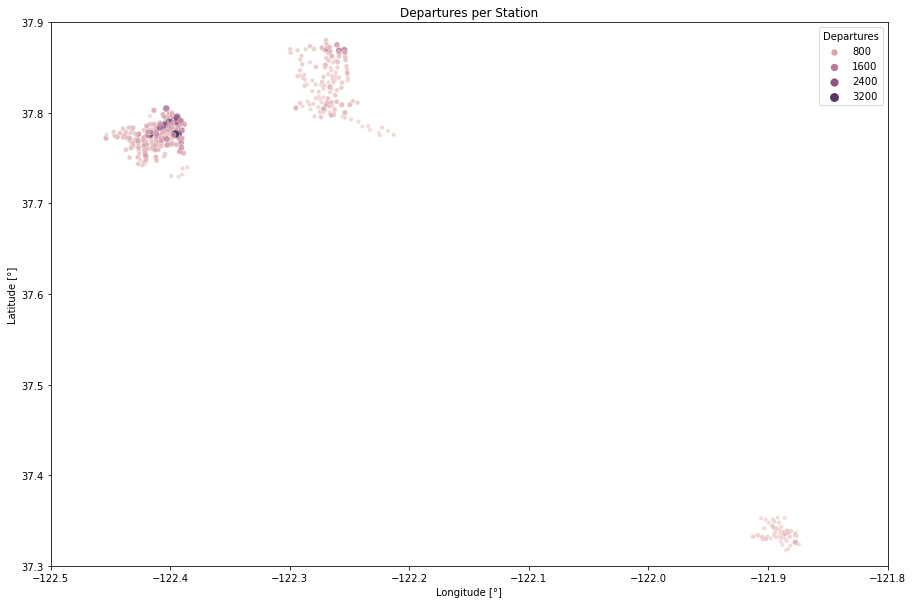

In [6]:
# create datafram using groupby

df_bike_geo_temp = bike.groupby(['start_station_name', 'start_station_id', 'start_station_longitude', 'start_station_latitude'])['station_multi'].count().reset_index()
df_bike_geo_temp.rename(columns = {'station_multi' : 'Departures'}, inplace = True)

# number of departures per station

plt.figure(figsize = [15, 10]) 
plt.title('Departures per Station')
plt.xlabel('Longitude [°]')
plt.ylabel('Latitude [°]')
plt.xlim(-122.5, -121.8)
plt.ylim(37.3, 37.9)

sb.scatterplot(data = df_bike_geo_temp, x = 'start_station_longitude', y = 'start_station_latitude', hue = 'Departures', size = 'Departures', alpha = 0.75, legend = 'brief');

## Number of Departures per Region, User Type and Day of the Week

The following plot shows number of rides in relationship to region, user type and day of week (0 = Monday, ... , 6 = Sunday). Major part of departures take place on working day in the west region by subscribers. Customers are a minor part of riders. The usage of the bike system is constant by this user type over all days of the week. 

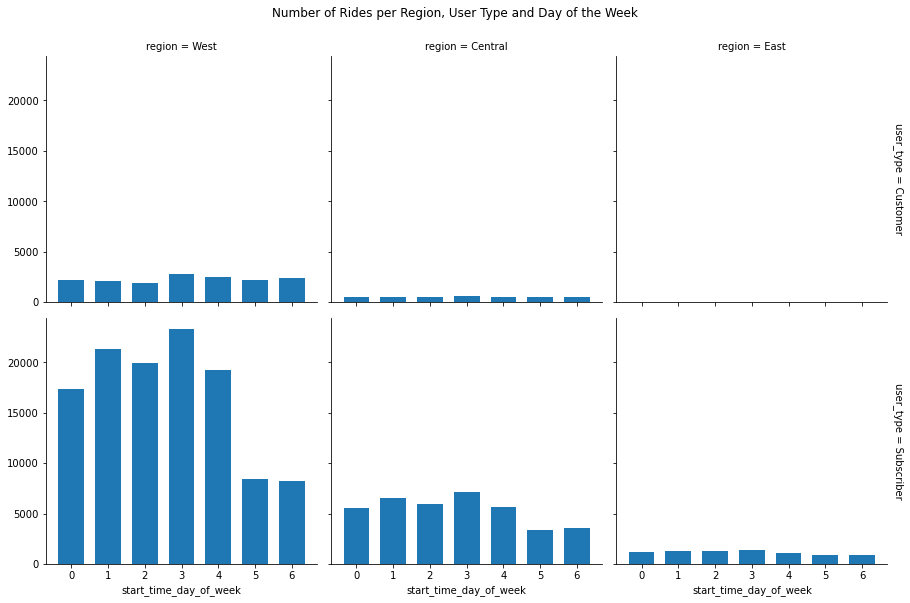

In [7]:
# set bins

bins = np.arange(- 0.5, bike.start_time_day_of_week.max() + 1.5, 1)

# create plot

g = sb.FacetGrid(data = bike, col = 'region', row = 'user_type', height = 4.25, margin_titles = True)
g.map(plt.hist, 'start_time_day_of_week', rwidth = 0.7, bins = bins)

# set title

plt.subplots_adjust(top = 0.9)
g.fig.suptitle('Number of Rides per Region, User Type and Day of the Week');

## Number of Departures per Region, User Type and Starting Hour

Using the same plot, but changing day of the week against hour of day shows the following. Subscribers in the west region use the bike system more frequent in the morning between 6 a.m. and 9 a.m. and between 4 p.m. and 6 p.m. There is also such a trend noticeable in the central region by subscribers.

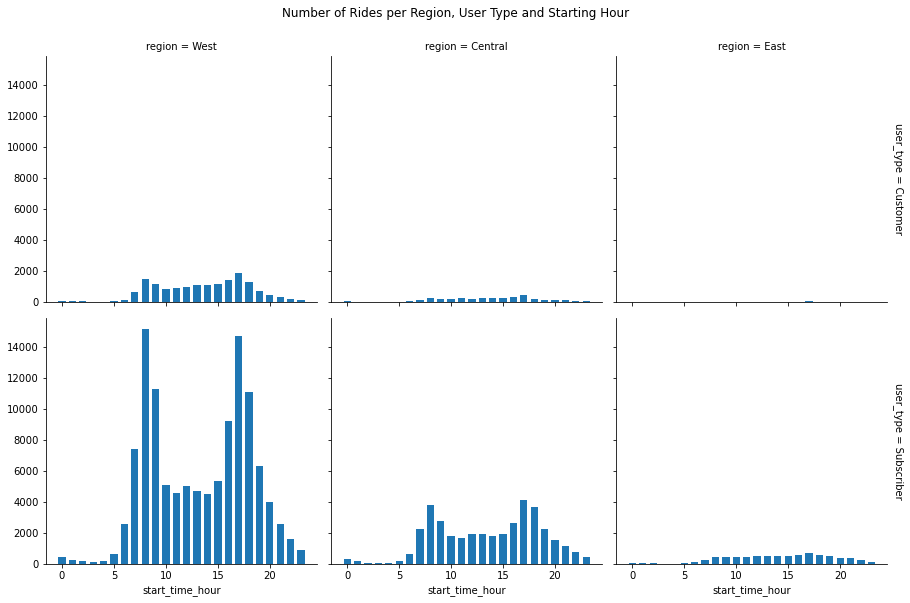

In [8]:
# set bins

bins = np.arange(- 0.5, bike.start_time_hour.max() + 1.5, 1)

# create plot

g = sb.FacetGrid(data = bike, col = 'region', row = 'user_type', height = 4.25, margin_titles = True)
g.map(plt.hist, 'start_time_hour', rwidth = 0.7, bins = bins)

# set title

plt.subplots_adjust(top = 0.9)
g.fig.suptitle('Number of Rides per Region, User Type and Starting Hour');

## Summary and Conclusion

My investigation shows that the bike system has its main purpose for commuting on working day in the west region. 